In [4]:
import pandas as pd
import numpy as np
import gc

In [9]:
# This is the DB I've been scrapping from biobiochile.cl
df_articles = pd.read_csv('./article_202310072058.csv', delimiter=';')
df_articles.head()

,article_hash,article_title,category,publish_date,article_body,raw_content,source_entity,article_link,generated_summary,negative_score,importance_score
0,cfca211bf39221671436397b140ea57a7a9268851dfef8...,Solicitan la caducidad de 166 concesiones acuí...,Nacional,2023-07-17 23:54:00.000,La región de Los Lagos es una de las regiones ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
1,de051d5444e79470f618b38588ea5988ce808ee1db192d...,Lota: Bomberos descarta que auto estacionado e...,Nacional,2023-07-17 23:10:00.000,Una camioneta se estacionó justo a la salida d...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
2,39dff9b324fe3fb40b70d8a25651e95d57e015ea274865...,Declaran emergencia ambiental para este martes...,Nacional,2023-07-17 23:02:00.000,La Delegación presidencial declaró emergencia ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
3,f4001720cfe06f5c0aa36c3d8b83bd25a2b8bad50e14c4...,Estudio revela preocupante aumento de tercera ...,Nacional,2023-07-17 21:58:00.000,Una de las razones de este aumento podría ser ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
4,8212613c7830f1466362f2dfc412c5675cde6376b752df...,"Denuncia de ""malos olores"": Municipalidad de Q...",Nacional,2023-07-17 21:18:00.000,La Municipalidad de Quilicura reportó la noche...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN


In [15]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5741 entries, 0 to 5740
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   article_hash       5741 non-null   object 
 1   article_title      5741 non-null   object 
 2   category           5741 non-null   object 
 3   publish_date       5741 non-null   object 
 4   article_body       5687 non-null   object 
 5   raw_content        5688 non-null   object 
 6   source_entity      5741 non-null   object 
 7   article_link       5741 non-null   object 
 8   generated_summary  0 non-null      float64
 9   negative_score     0 non-null      float64
 10  importance_score   0 non-null      float64
dtypes: float64(3), object(8)
memory usage: 493.5+ KB


In [22]:
df_articles = df_articles.drop(index=df_articles[df_articles['article_body'].isnull() == True].index)

In [23]:
print('Average title length: ', int(np.average(df_articles['article_title'].str.len())))
print('Minimum title length: ', int(np.min(df_articles['article_title'].str.len())))
print('Maximum title length: ', int(np.max(df_articles['article_title'].str.len())))

Average title length:  93
Minimum title length:  38
Maximum title length:  102


In [24]:
print('Average body length: ', int(np.average(df_articles['article_body'].str.len())))
print('Minimum body length: ', int(np.min(df_articles['article_body'].str.len())))
print('Maximum body length: ', int(np.max(df_articles['article_body'].str.len())))

Average body length:  2141
Minimum body length:  15
Maximum body length:  31870


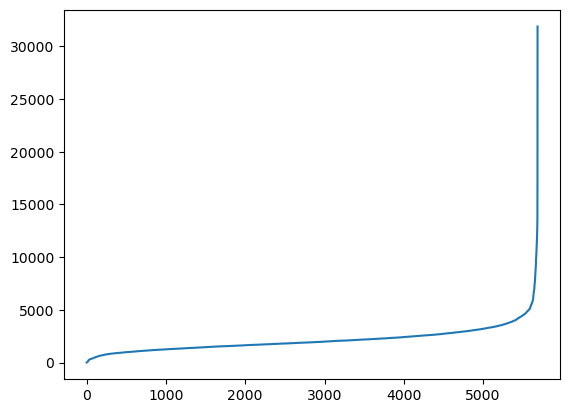

In [37]:
body_len = df_articles['article_body'].str.len()
body_len = body_len.sort_values()
body_len.reset_index(inplace=True, drop=True)
body_len.plot();

In [45]:
df_articles[df_articles['article_body'].str.len() > 30000]['article_link'].values

array(['https://www.biobiochile.cl/especial/nuevo-proceso-constituyente/noticias/2023/09/26/todos-los-articulos-aprobados-por-el-consejo-constitucional-hasta-ahora.shtml'],
      dtype=object)

In [1]:
import torch
from transformers import BertTokenizerFast, EncoderDecoderModel
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [2]:
def generate_summary(text):
   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model.generate(input_ids, attention_mask=attention_mask)
   return tokenizer.decode(output[0], skip_special_tokens=True)

In [3]:
device

'cuda'

In [5]:
def getChunks(article):
    parts = article.split('.')
    df = pd.DataFrame(parts)
    df.columns = ['article_parts']
    df = df[df['article_parts'].str.len() > 0]
    return df.to_numpy().squeeze()

In [6]:
def mergeChunks(number, chunks):
    import math

    # Calculate the number of splits
    splits = math.ceil((len(chunks) / number) - 0.5)

    # Create an empty result list to store merged chunks
    result = []

    # Loop through and merge the chunks
    for i in range(splits):
        start = i * number
        end = min((i + 1) * number, len(chunks))
        chunk = chunks[start:end]
        merged_chunk = ". ".join(chunk)
        result.append(merged_chunk)

    return result

In [158]:
chunks = getChunks(whole_article)
chunks
merged_chunks = mergeChunks(int(len(chunks)/8), chunks)
print('Text paragraphs:', len(merged_chunks))

Text paragraphs: 8


In [159]:
for i in range(len(merged_chunks)):
    merged_chunks[i] = merged_chunks[i] + '.'
    merged_chunks[i] = merged_chunks[i].strip()

In [160]:
merged_chunks

['¿Qué piezas usar? El nuevo presidente de la Cámara de Diputados agarró las blancas y jugó primero.  A semanas de cumplirse 50 años del Golpe de Estado, Ricardo Cifuentes (DC) convocó a una cita entre bancadas para definir la actividad que realizarán el 11/S.  ¿Feriado, minuto de silencio o nada? Eso está por verse, pero lo cierto es que al profesor de historia no le basta con mover un solo peón.  Esta partida, tan reflexiva como una de ajedrez, podría marcar el legado de la Democracia Cristiana en la testera.  Nacional El adiós de Patricio Fernández a La Moneda, la medalla a Baltasar Garzón y la infructuosa invitación de Gabriel Boric a firmar una carta son parte de los hitos que han copado los titulares en la previa a los 50 años del Golpe de Estado.  Lejos de poner en relieve las polémicas, estas acciones grafican la realidad: no hay una mirada unívoca respecto a lo ocurrido la mañana del 11 de septiembre de 1973.  En el caso de la Cámara, son 155 diputados y 22 partidos los que co

In [161]:
%%time
summaries_1 = []
for mc in merged_chunks:
    smm = generate_summary(mc)
    summaries_1.append(smm)
    print(smm)

El homenaje de Patricio Fernández a La Moneda, la medalla a Baltasar Garzón y la infructuosa invitación de Gabriel Boric a firmar una carta son parte de los hitos
El presidente de la Cámara de Diputados de Chile ha asumido una actitud cauta y cauta
El congresista que dirigió durante siete años la Secretaría Regional de Planificación de la Universidad Católica de Valparaíso celebra los 50 años del golpe
El nuevo timonel de la cámara de la Cámara de Diputados descarta que Cifuentes fuera elegido por su relación con Renán Fuentealba
El académico Cristián Pérez pide a la Cámara no lavarse las manos
El presidente de la Cámara de Diputados podría convertirse en árbitro de la partida para el 11 / S
Las primeras miradas se posan sobre Hertz, la primera vicepresidenta de la Cámara
El 58 % de los encuestados cree que Chile seguirá igual que siempre tras el 11 de septiembre
CPU times: user 1min 1s, sys: 1.11 s, total: 1min 2s
Wall time: 32.9 s


In [165]:
# Testing merging the summaries to further compact summaries as an attempt to reduce some problems
if len(summaries_1) % 2 == 0:
    merged_summaries_1 = [summaries_1[i] + '. ' + summaries_1[i+1] for i in range(0, len(summaries_1), 2)]
else:
    merged_summaries_1 = [summaries_1[i] + '. ' + summaries_1[i+1] for i in range(0, len(summaries_1)-1, 2)]
    merged_summaries_1.append(summaries_1[-1])
merged_summaries_1

['El homenaje de Patricio Fernández a La Moneda, la medalla a Baltasar Garzón y la infructuosa invitación de Gabriel Boric a firmar una carta son parte de los hitos. El presidente de la Cámara de Diputados de Chile ha asumido una actitud cauta y cauta',
 'El congresista que dirigió durante siete años la Secretaría Regional de Planificación de la Universidad Católica de Valparaíso celebra los 50 años del golpe. El nuevo timonel de la cámara de la Cámara de Diputados descarta que Cifuentes fuera elegido por su relación con Renán Fuentealba',
 'El académico Cristián Pérez pide a la Cámara no lavarse las manos. El presidente de la Cámara de Diputados podría convertirse en árbitro de la partida para el 11 / S',
 'Las primeras miradas se posan sobre Hertz, la primera vicepresidenta de la Cámara. El 58 % de los encuestados cree que Chile seguirá igual que siempre tras el 11 de septiembre']

In [166]:
%%time
summaries_1_merged = []
for mc in merged_summaries_1:
    smm = generate_summary(mc)
    summaries_1_merged.append(smm)
    print(smm)

El homenaje de Patricio Fernández a La Moneda, la medalla a Baltasar Garzón y la infructuosa invitación de Gabriel Boric a firmar una carta son parte de los hitos
El congresista que dirigió durante siete años la Secretaría Regional de Planificación de la Universidad Católica de Valparaíso celebra los 50 años del golpe. El nuevo timonel de la cámara de la Cámara de Diputados descarta que Cifuentes fuera elegido por su relación con Renán Fuentealbaba
El académico Cristián Pérez pide a la Cámara no lavarse las manos. El presidente de la Cámara de Diputados podría convertirse en árbitro de la partida para el 11 - S
El 58 % de los encuestados cree que Chile seguirá igual que siempre tras el 11 de septiembre
CPU times: user 44.2 s, sys: 821 ms, total: 45 s
Wall time: 23.6 s


In [163]:
!sudo apt install libenchant1c2a -y

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libenchant1c2a is already the newest version (1.6.0-11.3build1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [30]:
!pip install pyenchant

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
!sudo apt install myspell-es

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  hunspell libreoffice-core | openoffice.org-hunspell | openoffice.org-core
  iceape-browser | iceweasel | icedove
The following NEW packages will be installed:
  myspell-es
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 201 kB of archives.
After this operation, 1004 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 myspell-es all 1.11-15 [201 kB]
Fetched 201 kB in 0s (2459 kB/s)   

78Selecting previously unselected package myspell-es.
(Reading database ... 108068 files a

In [43]:
import enchant

print(enchant.list_languages())

d = enchant.Dict('es_CL')

def checkDict(word):
    return d.check(word)

['en', 'en_AU', 'en_CA', 'en_GB', 'en_US', 'es_ES', 'es_DO', 'es_SV', 'es_NI', 'es_CR', 'es_PE', 'es_GT', 'es_CL', 'es_PR', 'es_CU', 'es_PY', 'es', 'es_VE', 'es_PA', 'es_HN', 'es_UY', 'es_MX', 'es_AR', 'es_BO', 'es_EC', 'es_CO']


In [85]:
import nltk
from nltk.metrics.distance import edit_distance

nltk.download('punkt')  # Download necessary NLTK data

def most_similar_word(target_word, text):
    words = nltk.word_tokenize(text)
    most_similar = None
    min_distance = float('inf')
    
    for word in words:
        distance = edit_distance(target_word, word)
        if distance < min_distance:
            min_distance = distance
            most_similar = word
    return most_similar

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
merged_summaries_1

['Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío. Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil',
 'El jefe comunal chintino asegura que el causante del accidente se había dormido al volante. La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital']

In [87]:
whole_article

'Ante el cierre del camino entre ambas comunas, el tránsito fue desviado hacia avenida Costanera para viajar desde Concepción a Chiguayante. Región del Bío Bío Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una importante congestión vehicular de más de 4 kilómetros en la capital regional del Bío Bío, principalmente en el sector Pedro de Valdivia. Según información preliminar, entregada por el alcalde de Chiguayante, Antonio Rivas, el choque en el sector Lonco, se habría originado luego de que un conductor que se dirigía de sur a norte, perdiera el control de su vehículo y cruzara el bandejón central, impactando a un segundo móvil. Luego, un tercer auto colisionó por alcance, dejando la calzada con el tránsito limitado. Es más, el jefe comunal chiguayantino aseguró que el causante del accidente se habría dormido al volante. “Uno de los conductores se quedó dormido y atravesó el eje central de la calzada y esto provocó un choque entre tres vehículos 

In [102]:
# Fixing weird words that the model generates trying to make summaries of weird Chilean words, and improve quality of generated summaries

import re

def replaceWeirdSummaries(whole_article, summaries):
    cleaned_article = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', whole_article)

    parts_text = cleaned_article.split(' ')

    rare_words = []

    for p in parts_text:
        if len(p) == 0:
            continue
        if checkDict(p) == False:
            rare_words.append(p)

    for i in range(len(summaries)):
        cleaned_summary = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', summaries[i])
        result = ''
        for t in cleaned_summary.split(' '):
            if t.lower() not in cleaned_article.lower() and  checkDict(t) == False:
                w = most_similar_word(t, ' '.join(rare_words))
                print(t, w)
                summaries[i] = str(summaries[i]).replace(t, w)
    print(summaries)
    
replaceWeirdSummaries(whole_article, summaries_1)

chintino chiguayantino
['Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío', 'Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil', 'El jefe comunal chiguayantino asegura que el causante del accidente se había dormido al volante', 'La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital']


In [108]:
summaries_1

['Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío',
 'Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil',
 'El jefe comunal chiguayantino asegura que el causante del accidente se había dormido al volante',
 'La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital']

### Evaluate Models

In [20]:
!pip install absl-py nltk six>=1.14
!pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a78db118a0f0f896f6cbbea0ab6ba81942be675c5e6a81afeab21e6afb84be8c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [104]:
def evaluateModel(reference, summaries):
    from rouge_score import rouge_scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = []
    for i in range(len(summaries)):
        score = rouge.score(reference[i], summaries[i])
        scores.append(score)
    return scores

In [105]:
scores_1 = evaluateModel(merged_chunks, summaries_1)

In [106]:
def printScores(scores):
    chunk=0
    for s in scores:
        chunk=chunk+1
        print('Chunk ', chunk)
        r1 = s['rouge1']
        print('scores:\t precision \t recall \t fmeasure')
        print(f'rouge1:\t {r1.precision:.5f} \t {r1.recall:.5f} \t {r1.fmeasure:.5f}')
        r2 = s['rougeL']
        print(f'rougeL:\t {r2.precision:.5f} \t {r2.recall:.5f} \t {r2.fmeasure:.5f}\n')
    

- "rouge1" considers the overlap of unigrams (individual words) between the generated text and reference text.
- "rougeL" is a longer matching measure that considers the longest common subsequence of words between the generated and reference text.

- "Precision" measures the proportion of the generated text that is relevant and matches the reference text. It's calculated as the number of correct matches divided by the total number of generated words.
- "Recall" measures the proportion of the reference text that is correctly captured by the generated text. It's calculated as the number of correct matches divided by the total number of reference words.
- "F-measure" is the harmonic mean of precision and recall and provides a balanced measure of both precision and recall. It's often used as an overall measure of the quality of the generated text.

Higher is better

In [107]:
printScores(scores_1)

Chunk  1
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.97222 	 0.47297 	 0.63636
rougeL:	 0.97222 	 0.47297 	 0.63636

Chunk  2
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.93103 	 0.38571 	 0.54545
rougeL:	 0.93103 	 0.38571 	 0.54545

Chunk  3
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.87500 	 0.24138 	 0.37838
rougeL:	 0.87500 	 0.24138 	 0.37838

Chunk  4
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.70370 	 0.41304 	 0.52055
rougeL:	 0.62963 	 0.36957 	 0.46575



In [109]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_summ = AutoTokenizer.from_pretrained("edumunozsala/RuPERTa_base_sentiment_analysis_es")
model_summ = AutoModelForSequenceClassification.from_pretrained("edumunozsala/RuPERTa_base_sentiment_analysis_es")

In [132]:
def getSentimentScore(summaries):
    results = []
    for s in summaries:
        input_ids = torch.tensor(tokenizer_summ.encode(s)).unsqueeze(0)
        outputs = model_summ(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=1)
        negative_sentiment_score = probabilities[0][0].item()
        positive_sentiment_score = probabilities[0][1].item()

        print(s)
        print("Scores: ", '-', negative_sentiment_score, '+',positive_sentiment_score)
        print()

In [133]:
getSentimentScore(summaries_1)

Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío
Scores:  - 0.010643890127539635 + 0.9893561005592346

Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil
Scores:  - 0.06757558137178421 + 0.9324243664741516

El jefe comunal chiguayantino asegura que el causante del accidente se había dormido al volante
Scores:  - 0.7908575534820557 + 0.20914246141910553

La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital
Scores:  - 0.03611600026488304 + 0.9638839960098267



In [167]:
import nltk
from nltk.corpus import stopwords

# Download the Spanish stop words list if you haven't already
nltk.download('stopwords')

def remove_stopwords(text):
    """
    Remove stop words from a text in Spanish.

    Args:
        text (str): The input text.

    Returns:
        str: The text with stop words removed.
    """
    # Tokenize the text into words
    words = nltk.word_tokenize(text, language='spanish')

    # Get the list of Spanish stop words
    spanish_stopwords = set(stopwords.words('spanish'))

    # Remove stop words from the list of words
    filtered_words = [word for word in words if word.lower() not in spanish_stopwords]

    # Reconstruct the text without stop words
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ejemplo texto palabras parada español .


In [171]:
for s in summaries_1:
    print(remove_stopwords(re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', s.lower())))

homenaje patricio fernández moneda medalla baltasar garzón infructuosa invitación gabriel boric firmar carta parte hitos
presidente cámara diputados chile asumido actitud cauta cauta
congresista dirigió siete años secretaría regional planificación universidad católica valparaíso celebra años golpe
nuevo timonel cámara cámara diputados descarta cifuentes elegido relación renán fuentealba
académico cristián pérez pide cámara lavarse manos
presidente cámara diputados podría convertirse árbitro partida s
primeras miradas posan hertz primera vicepresidenta cámara
encuestados cree chile seguirá igual siempre tras septiembre
